In [ ]:
import os
import cv2
import pickle
import itertools
%matplotlib inline
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import tensorflow as tf
from keras import layers
from sklearn import metrics
import matplotlib.pyplot as plt
from keras.models import Sequential
from sklearn.metrics import accuracy_score
from keras.utils.np_utils import to_categorical
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

## **Image Resizing:**

In [ ]:
def Dataset_loader(DIR, RESIZE):
  features = [] 
  for img in tqdm(os.listdir(DIR)):
    img_path = os.path.join(DIR, img)
    img_arr = cv2.imread(img_path)
    img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
    img_arr = cv2.resize(img_arr, (RESIZE, RESIZE))
    features.append(np.array(img_arr))
  return features    

benign_train = np.array(Dataset_loader('/content/drive/MyDrive/melanoma_cancer_dataset/train/benign', 170))
malign_train = np.array(Dataset_loader('/content/drive/MyDrive/melanoma_cancer_dataset/train/malignant', 170))
benign_test = np.array(Dataset_loader('/content/drive/MyDrive/melanoma_cancer_dataset/test/benign', 170))
malign_test = np.array(Dataset_loader('/content/drive/MyDrive/melanoma_cancer_dataset/test/malignant', 170))

100%|██████████| 606/606 [06:52<00:00,  1.47it/s]


# **Creating Labels:**

In [ ]:
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test)) 

X_train = np.concatenate((benign_train, malign_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train, 
    test_size=0.2, 
    random_state=11
)

In [ ]:
os.chdir("/content/drive/MyDrive/melanoma_cancer_dataset/Exp")
x_train = pickle.load(open("x_train.pkl", "rb"))
x_val = pickle.load(open("x_val.pkl", "rb"))
y_train = pickle.load(open("y_train.pkl", "rb"))
y_val = pickle.load(open("y_val.pkl", "rb"))

In [ ]:
X_test = pickle.load(open("X_test.pkl", "rb"))
Y_test = pickle.load(open("Y_test.pkl", "rb"))

# **Displaying Dataset Images:**



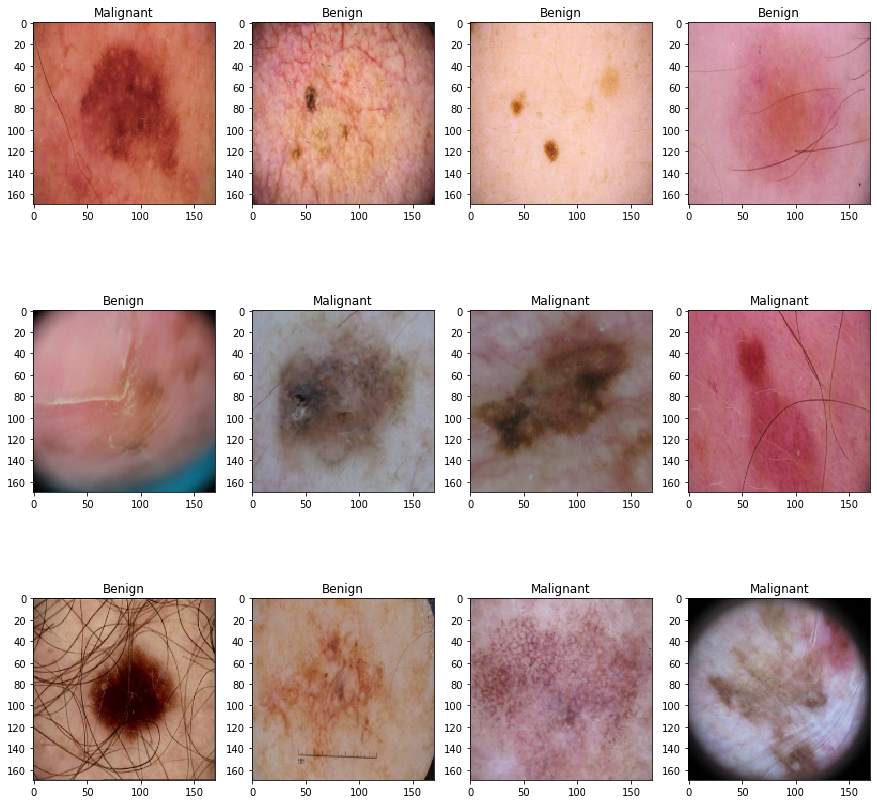

In [ ]:
w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

## **Creating Base Model Layers:**

In [ ]:
def build_model(backbone):
    model = Sequential()
    
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='softmax'))
    
    
    model.compile(loss = "categorical_crossentropy",
             optimizer = tf.keras.optimizers.Adam(),
             metrics = ['accuracy'])
    
    return model

## **Model1: ResNet 50**

In [ ]:
resnet = tf.keras.applications.ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(170,170,3)
)
model = build_model(resnet )

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
filepath = "resnet50_2.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor = "val_accuracy", verbose = 1, save_best_only = True, mode = "max")
# Early Stopping
#early_stop = EarlyStopping(monitor = "val_loss", verbose= 1, patience = 3)
callbacks_list = [checkpoint]

In [ ]:
history = model.fit(
    x_train, y_train, batch_size=32,
    steps_per_epoch=x_train.shape[0] / 32,
    epochs=30,
    validation_data=(x_val, y_val),
    callbacks = callbacks_list
)

Epoch 1/30
238/237 [==============================] - ETA: 0s - loss: 0.3556 - accuracy: 0.8657
Epoch 00001: val_accuracy improved from -inf to 0.90421, saving model to resnet50_2.hdf5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


237/237 [==============================] - 159s 507ms/step - loss: 0.3556 - accuracy: 0.8657 - val_loss: 0.2432 - val_accuracy: 0.9042
Epoch 2/30
238/237 [==============================] - ETA: 0s - loss: 0.2735 - accuracy: 0.8932
Epoch 00002: val_accuracy improved from 0.90421 to 0.91158, saving model to resnet50_2.hdf5
237/237 [==============================] - 120s 505ms/step - loss: 0.2735 - accuracy: 0.8932 - val_loss: 0.2613 - val_accuracy: 0.9116
Epoch 3/30
238/237 [==============================] - ETA: 0s - loss: 0.2942 - accuracy: 0.8916
Epoch 00003: val_accuracy did not improve from 0.91158
237/237 [==============================] - 118s 496ms/step - loss: 0.2942 - accuracy: 0.8916 - val_loss: 0.5054 - val_accuracy: 0.8211
Epoch 4/30
238/237 [==============================] - ETA: 0s - loss: 0.2724 - accuracy: 0.8971
Epoch 00004: val_accuracy did not improve from 0.91158
237/237 [==============================] - 115s 486ms/step - loss: 0.2724 - accuracy: 0.8971 - val_loss: 

In [ ]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/melanoma_cancer_dataset/Exp/model__1.hdf5')

In [ ]:
Y_pred = model.predict(x_val)

In [ ]:
Y_pred.shape

(1900, 2)

In [ ]:
Y_pred[1]

array([0.06722172, 0.93277824], dtype=float32)

In [ ]:
Y_pred[1:5]

array([[0.06722172, 0.93277824],
       [0.97628546, 0.02371453],
       [0.00227439, 0.99772567],
       [0.8119032 , 0.18809687]], dtype=float32)

In [ ]:
print("Accuracy of Resnet50 is: ", accuracy_score(y_val, np.argmax(Y_pred, axis = 1)))

Accuracy of Resnet50 is:  0.9205263157894736


**Classification Report:**

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

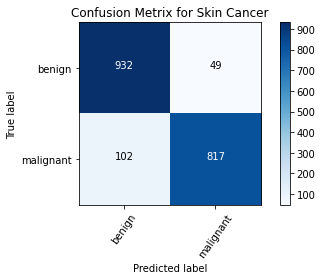

In [ ]:
cm = confusion_matrix(y_val, np.argmax(Y_pred, axis=1))
cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Skin Cancer')

In [ ]:
target_names = ['benign', 'malignant']    
print(classification_report(y_val, np.argmax(Y_pred, axis=1), target_names=target_names))

              precision    recall  f1-score   support

      benign       0.90      0.95      0.93       981
   malignant       0.94      0.89      0.92       919

    accuracy                           0.92      1900
   macro avg       0.92      0.92      0.92      1900
weighted avg       0.92      0.92      0.92      1900



# **Model2: EfficientNet**

In [ ]:
efficientNet = tf.keras.applications.EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(170,170,3)
)
model2 = build_model(efficientNet )

16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
filepath = "efficientNet.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor = "val_accuracy", verbose = 1, save_best_only = True, mode = "max")
callbacks_list = [checkpoint]

In [ ]:
history2 = model2.fit(
    x_train, y_train, batch_size=32,
    steps_per_epoch=x_train.shape[0] / 32,
    epochs=30,
    validation_data=(x_val, y_val),
    callbacks = callbacks_list
)

Epoch 1/30
238/237 [==============================] - ETA: 0s - loss: 0.2949 - accuracy: 0.8845
Epoch 00001: val_accuracy improved from -inf to 0.76158, saving model to efficientNet.hdf5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


237/237 [==============================] - 135s 394ms/step - loss: 0.2949 - accuracy: 0.8845 - val_loss: 0.5653 - val_accuracy: 0.7616
Epoch 2/30
238/237 [==============================] - ETA: 0s - loss: 0.2055 - accuracy: 0.9179
Epoch 00002: val_accuracy improved from 0.76158 to 0.94526, saving model to efficientNet.hdf5
237/237 [==============================] - 91s 383ms/step - loss: 0.2055 - accuracy: 0.9179 - val_loss: 0.1452 - val_accuracy: 0.9453
Epoch 3/30
238/237 [==============================] - ETA: 0s - loss: 0.1857 - accuracy: 0.9289
Epoch 00003: val_accuracy improved from 0.94526 to 0.95474, saving model to efficientNet.hdf5
237/237 [==============================] - 91s 382ms/step - loss: 0.1857 - accuracy: 0.9289 - val_loss: 0.1530 - val_accuracy: 0.9547
Epoch 4/30
238/237 [==============================] - ETA: 0s - loss: 0.1592 - accuracy: 0.9416
Epoch 00004: val_accuracy did not improve from 0.95474
237/237 [==============================] - 89s 374ms/step - loss: 

In [ ]:
model2 = load_model('/content/drive/MyDrive/melanoma_cancer_dataset/Exp/model__2.hdf5')

In [ ]:
Y_pred2 = model2.predict(x_val)

In [ ]:
print("Accuracy of EfficientNet is: ", accuracy_score(y_val, np.argmax(Y_pred2, axis = 1)))

Accuracy of EfficientNet is:  0.9394736842105263


**Classification Report:**

In [ ]:
print(classification_report(y_val, np.argmax(Y_pred2, axis = 1), target_names=target_names))

              precision    recall  f1-score   support

      benign       0.95      0.93      0.94       981
   malignant       0.92      0.95      0.94       919

    accuracy                           0.94      1900
   macro avg       0.94      0.94      0.94      1900
weighted avg       0.94      0.94      0.94      1900



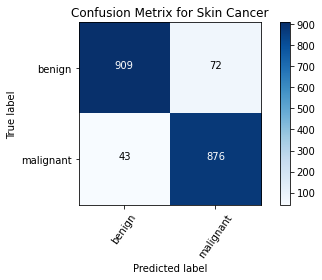

In [ ]:
cm = confusion_matrix(y_val, np.argmax(Y_pred2, axis=1))
cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Skin Cancer')

# **Model3: InceptionV3**

In [ ]:
InceptionV3 = tf.keras.applications.inception_v3.InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=(170,170,3)
)
model3 = build_model(InceptionV3 )

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
filepath = "InceptionV3.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor = "val_accuracy", verbose = 1, save_best_only = True, mode = "max")
callbacks_list = [checkpoint]

In [ ]:
history3 = model3.fit(
    x_train, y_train, batch_size=32,
    steps_per_epoch=x_train.shape[0] / 32,
    epochs=30,
    validation_data=(x_val, y_val),
    callbacks = callbacks_list
)

Epoch 1/30
238/237 [==============================] - ETA: 0s - loss: 0.3792 - accuracy: 0.8557
Epoch 00001: val_accuracy improved from -inf to 0.76263, saving model to InceptionV3.hdf5
237/237 [==============================] - 127s 363ms/step - loss: 0.3792 - accuracy: 0.8557 - val_loss: 108.9602 - val_accuracy: 0.7626
Epoch 2/30
238/237 [==============================] - ETA: 0s - loss: 0.2687 - accuracy: 0.8997
Epoch 00002: val_accuracy improved from 0.76263 to 0.93789, saving model to InceptionV3.hdf5
237/237 [==============================] - 84s 355ms/step - loss: 0.2687 - accuracy: 0.8997 - val_loss: 0.1923 - val_accuracy: 0.9379
Epoch 3/30
238/237 [==============================] - ETA: 0s - loss: 0.2340 - accuracy: 0.9088
Epoch 00003: val_accuracy improved from 0.93789 to 0.93895, saving model to InceptionV3.hdf5
237/237 [==============================] - 84s 355ms/step - loss: 0.2340 - accuracy: 0.9088 - val_loss: 0.2088 - val_accuracy: 0.9389
Epoch 4/30
238/237 [===========

In [ ]:
model3 = load_model('/content/drive/MyDrive/melanoma_cancer_dataset/Exp/model__3.hdf5')

In [ ]:
Y_pred3 = model3.predict(x_val)

In [ ]:
print("Accuracy of InceptionV3 is: ", accuracy_score(y_val, np.argmax(Y_pred3, axis = 1)))

Accuracy of InceptionV3 is:  0.9163157894736842


**Classification Report:**

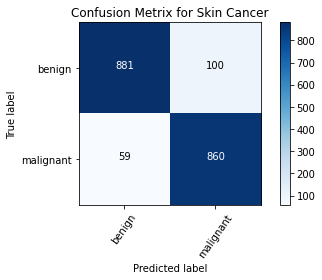

In [ ]:
cm = confusion_matrix(y_val, np.argmax(Y_pred3, axis=1))
cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Skin Cancer')

In [ ]:
print(classification_report(y_val, np.argmax(Y_pred3, axis = 1), target_names=target_names))

              precision    recall  f1-score   support

      benign       0.94      0.90      0.92       981
   malignant       0.90      0.94      0.92       919

    accuracy                           0.92      1900
   macro avg       0.92      0.92      0.92      1900
weighted avg       0.92      0.92      0.92      1900



# **Model4: Xception**

In [ ]:
Xception =tf.keras.applications.xception.Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(170,170,3)
)
model4 = build_model(Xception )

83697664/83683744 [==============================] - 2s 0us/step


In [ ]:
filepath = "Xception.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor = "val_accuracy", verbose = 1, save_best_only = True, mode = "max")
callbacks_list = [checkpoint]

In [ ]:
history4 = model4.fit(
    x_train, y_train, batch_size=32,
    steps_per_epoch=x_train.shape[0] / 32,
    epochs=30,
    validation_data=(x_val, y_val),
    callbacks = callbacks_list
)

Epoch 1/30
238/237 [==============================] - ETA: 0s - loss: 0.2995 - accuracy: 0.8839
Epoch 00001: val_accuracy improved from -inf to 0.92526, saving model to Xception.hdf5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


237/237 [==============================] - 212s 857ms/step - loss: 0.2995 - accuracy: 0.8839 - val_loss: 0.2378 - val_accuracy: 0.9253
Epoch 2/30
238/237 [==============================] - ETA: 0s - loss: 0.2095 - accuracy: 0.9228
Epoch 00002: val_accuracy did not improve from 0.92526
237/237 [==============================] - 193s 813ms/step - loss: 0.2095 - accuracy: 0.9228 - val_loss: 0.2141 - val_accuracy: 0.9089
Epoch 3/30
238/237 [==============================] - ETA: 0s - loss: 0.1703 - accuracy: 0.9351
Epoch 00003: val_accuracy improved from 0.92526 to 0.92737, saving model to Xception.hdf5
237/237 [==============================] - 201s 847ms/step - loss: 0.1703 - accuracy: 0.9351 - val_loss: 0.1603 - val_accuracy: 0.9274
Epoch 4/30
238/237 [==============================] - ETA: 0s - loss: 0.1562 - accuracy: 0.9401
Epoch 00004: val_accuracy improved from 0.92737 to 0.94579, saving model to Xception.hdf5
237/237 [==============================] - 201s 845ms/step - loss: 0.156

In [ ]:
model4 = load_model('/content/drive/MyDrive/melanoma_cancer_dataset/Exp/model__4.hdf5')

In [ ]:
Y_pred4 = model4.predict(x_val)

In [ ]:
Y_pred4.shape

(1900, 2)

In [ ]:
Y_pred4[1]

array([0.00102659, 0.99897337], dtype=float32)

In [ ]:
print("Accuracy of Xception is: ", accuracy_score(y_val, np.argmax(Y_pred4, axis = 1)))

Accuracy of Xception is:  0.9363157894736842


**Classification Report:**

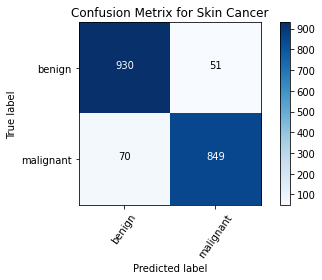

In [ ]:
cm = confusion_matrix(y_val, np.argmax(Y_pred4, axis=1))
cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Skin Cancer')

In [ ]:
print(classification_report(y_val, np.argmax(Y_pred4, axis=1), target_names=target_names))

              precision    recall  f1-score   support

      benign       0.93      0.95      0.94       981
   malignant       0.94      0.92      0.93       919

    accuracy                           0.94      1900
   macro avg       0.94      0.94      0.94      1900
weighted avg       0.94      0.94      0.94      1900



# **Ensemble of Models:**

In [ ]:
from keras.models import load_model

In [ ]:
def load_all_models(n_models):
	all_models = list()
	for i in range(n_models):
		filename = 'model__' + str(i + 1) + '.hdf5'
		model = load_model(filename)
		all_models.append(model)
		print('>loaded %s' % filename)
	return all_models
# load all models
n_members = 4
members = load_all_models(n_members)
print('Loaded %d models' % len(members))  

>loaded model__1.hdf5
>loaded model__2.hdf5
>loaded model__3.hdf5
>loaded model__4.hdf5
Loaded 4 models


In [ ]:
from numpy import dstack
# create stacked model input dataset as outputs from the ensemble
def stacked_dataset(members, inputX):
	stackX = None
	for model in members:
		yhat = model.predict(inputX, verbose=0)
		if stackX is None:
			stackX = yhat
		else:
			stackX = dstack((stackX, yhat))
	stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
	return stackX

In [ ]:
stackX1 = None
for model in members:
  yhat1 = model.predict(x_val, verbose=0)
  if stackX1 is None:
    stackX1 = yhat1
  else:
    stackX1 = dstack((stackX1, yhat1))

In [ ]:
stackX1.shape

(1900, 2, 4)

In [ ]:
stackX1[1]

array([[6.7221723e-02, 1.8646234e-06, 7.1174823e-02, 1.0265851e-03],
       [9.3277824e-01, 9.9999809e-01, 9.2882514e-01, 9.9897349e-01]],
      dtype=float32)

In [ ]:
stackX1 = stackX1.reshape((stackX1.shape[0], stackX1.shape[1]*stackX1.shape[2]))

In [ ]:
stackX1.shape

(1900, 8)

In [ ]:
stackX1[1]

array([6.7221723e-02, 1.8646234e-06, 7.1174823e-02, 1.0265851e-03,
       9.3277824e-01, 9.9999809e-01, 9.2882514e-01, 9.9897349e-01],
      dtype=float32)

In [ ]:
stacked_input = stacked_dataset(members, x_val) # create dataset using ensemble

In [ ]:
stacked_input.shape

(1900, 8)

In [ ]:
stacked_input[1:5]

array([[6.72217235e-02, 1.86462341e-06, 7.11748227e-02, 1.02658512e-03,
        9.32778239e-01, 9.99998093e-01, 9.28825140e-01, 9.98973489e-01],
       [9.76285458e-01, 9.99886751e-01, 8.88316572e-01, 9.86177325e-01,
        2.37145349e-02, 1.13181792e-04, 1.11683406e-01, 1.38226645e-02],
       [2.27438682e-03, 4.74294880e-04, 1.55116751e-13, 9.69599114e-07,
        9.97725666e-01, 9.99525666e-01, 1.00000000e+00, 9.99999046e-01],
       [8.11903179e-01, 5.12202322e-01, 4.43859935e-01, 8.01881254e-01,
        1.88096866e-01, 4.87797707e-01, 5.56140065e-01, 1.98118806e-01]],
      dtype=float32)

In [ ]:
y_val[1:5]

array([1., 0., 1., 0.])

In [ ]:
from sklearn.linear_model import LogisticRegression
model_stack = LogisticRegression()
model_stack.fit(stacked_input, y_val)

LogisticRegression()

# **Classification Report:**

Results on Validation Data

In [ ]:
Stacked_validation = stacked_dataset(members, x_val)
yhat_validation = model_stack.predict(Stacked_validation)

In [ ]:
acc_validationt = accuracy_score(y_val, yhat_validation)
print('Stacked Validation Accuracy: %.3f' % acc_validationt)

Stacked Validation Accuracy: 0.959


In [ ]:
target_names = ['benign', 'malignant']   
print(classification_report(y_val, yhat_validation, target_names=target_names))

              precision    recall  f1-score   support

      benign       0.95      0.97      0.96       981
   malignant       0.97      0.95      0.96       919

    accuracy                           0.96      1900
   macro avg       0.96      0.96      0.96      1900
weighted avg       0.96      0.96      0.96      1900



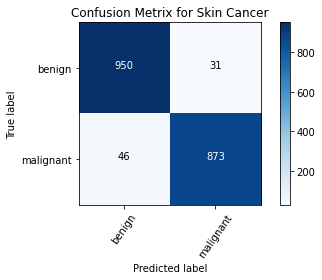

In [ ]:
cm = confusion_matrix(y_val, yhat_validation)
cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Skin Cancer')

Results on Test Data:

In [ ]:
Stacked_test = stacked_dataset(members, X_test)
yhat_test = model_stack.predict(Stacked_test)

In [ ]:
yhat_test[:5]

array([1., 1., 0., 1., 1.])

In [ ]:
acc_test = accuracy_score(Y_test, yhat_test)
print('Stacked Test Accuracy: %.3f' % acc_test)

Stacked Test Accuracy: 0.931


In [ ]:
print(classification_report(Y_test, yhat_test, target_names=target_names))

              precision    recall  f1-score   support

      benign       0.89      0.97      0.93       500
   malignant       0.97      0.90      0.94       606

    accuracy                           0.93      1106
   macro avg       0.93      0.93      0.93      1106
weighted avg       0.93      0.93      0.93      1106



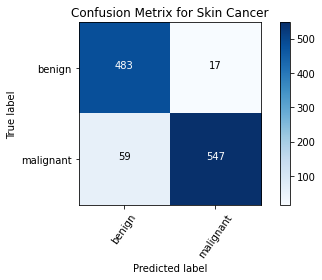

In [ ]:
cm = confusion_matrix(Y_test, yhat_test)
cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Skin Cancer')

In [ ]:
Y_pred_test = model.predict(X_test)
Y_pred2_test = model2.predict(X_test)
Y_pred3_test = model3.predict(X_test)
Y_pred4_test = model4.predict(X_test)

In [ ]:
print("ResNet50 Accuracy:     %.3f"% accuracy_score(Y_test, np.argmax(Y_pred_test, axis = 1)))
print("EfficientNet Accuracy: %.3f"% accuracy_score(np.argmax(to_categorical(Y_test),axis = 1), np.argmax(Y_pred2_test, axis = 1)))
print("InceptionV3 Accuracy:  %.3f"% accuracy_score(Y_test, np.argmax(Y_pred3_test, axis = 1)))
print("Xception Accuracy:     %.3f"% accuracy_score(Y_test, np.argmax(Y_pred4_test, axis = 1)))

ResNet50 Accuracy:     0.922 
EfficientNet Accuracy: 0.910
InceptionV3 Accuracy:  0.917
Xception Accuracy:     0.921
